In [1]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex

import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta
import cvxpy as cp


## Group Assignment
### Team Number: 07
### Team Member Names: Wendi Xue, Ammar Adam, Maximilian Bartoszek
### Team Strategy Chosen: Risk-Free (Market Beat, Market Meet, Risk-Free)

Runtime is expected to be less than 2m. With a list of 200 tickers, consisting of many fakes and international tickers, it took 1m 17s.

With a similar list of 621 tickers, 487 of which being valid, the program took 5m 58s to produce a result.

With the example csv, it took 1m 18s one time, and then 24s another.

### Loading and filtering valid tickers
In the secret list of tickers that will be used to generate our portfolio, we will take into consideration the following factors:
- If there are any duplicate tickers in the list, we will drop them.
- If there are any tickers in the list that do not exist, using the function info.get() will prevent any KeyErrors
- We only want valid US and Canadian companies that have listed stocks in the markets, so we will only take stocks with United States or Canada as their country and CAD and USD as their currency

In [2]:
# Load the tickers
df = pd.read_csv('Tickers (1).csv', header=None) # test with Tickers_Example.csv?
# If there are any duplicate tickers, we will drop them
df = df.drop_duplicates()
ticker_lst = list(df.iloc[:,0])

# Filter out tickers that don't exist; include only valid tickers
valid_tickers_lst = []
for ticker in ticker_lst:
    try: 
        ticker_data = yf.Ticker(ticker) # call up data
        country = ticker_data.info.get('country') 
        currency = ticker_data.info.get('currency')
        if country in {'Canada','United States'} and currency in {'CAD','USD'}: # filters us and canadian tickers and listed stocks
            valid_tickers_lst.append(ticker.strip())
    except Exception as err:
        print(f"Error: {err}")

print(valid_tickers_lst)

HTTP Error 404: 
HTTP Error 404: 


['SU.TO', 'ABBV', 'LOW', 'AUST', 'TD', 'AMZN', 'AXP', 'GCT', 'BK', 'EXE.TO', 'CMCSA', 'SHOP', 'COST', 'CSCO', 'GM', 'GOOG', 'AIM.TO', 'FTG.TO', 'ORCL', 'SAP.TO', 'DUOL', 'PEP', 'T.TO', 'SLB', 'SO', 'SPG', 'SHOP.TO', 'RY.TO', 'TD.TO', 'AW.TO', 'XZO']


## Average daily volume constraint
- If the stock does not have any information on their volume on a specific day, we will drop that day.
- Between October 1, 2024 and September 30, 2025, we will group together the data of the volume by months to see if there are months with less than 18 trading days. If there is we will drop that month when calculating the average daily volume.
- If any stock has an average daily volume below 5,000 shares we will exclude that stock from the list of tickers.

In [19]:
# Apply a filter to remove all stocks with volumes below 5000 (in the given period)
# period in which we look at the volumes 
volume_start_date = '2024-10-01'
volume_end_date = '2025-09-30' 
filtered_lst = []

for ticker in valid_tickers_lst: # goes through every ticker to filter
    try: 
        data = yf.download(
            tickers=ticker,
            start=volume_start_date,
            end=volume_end_date,
            auto_adjust=True
        )
        volume_data = data[['Volume']].dropna() # volume data
    
        keep_months = pd.DataFrame() # df of all the months with more than 18 trading days
        volume_data['Month'] = volume_data.index.to_period('M') # create new column of index only by (YYYY-MM)
        grouped_month_index = volume_data.groupby(['Month']) # group data by month
    
        for month, group in grouped_month_index:
            if len(group) >= 18: # if the month has more than 18 trading days
                keep_months = pd.concat([keep_months, group]) # add data of months with more than 18 trading days
    
        average_daily_volume = keep_months['Volume'][ticker].mean() # calculate average daily volume
        if average_daily_volume >= 5000: # determine if above or below 5000 shares
            filtered_lst.append(ticker) # add to filtered list if greater or equal to 5000 shares
    except Exception as err:
        # IF something produces an error, then it would have become public in Oct 2025 or later
        # We don't like this (it'll be volatile) so we'll just remove it
        print(f"Error: {err}")

print(filtered_lst)

# Get the daily data over chosen timeframe
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

daily_data = yf.download(
    tickers=filtered_lst,
    start=start_date,
    end=end_date, 
    auto_adjust=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

Error: 'Volume'
['SU.TO', 'ABBV', 'LOW', 'AUST', 'TD', 'AMZN', 'AXP', 'GCT', 'BK', 'EXE.TO', 'CMCSA', 'SHOP', 'COST', 'CSCO', 'GM', 'GOOG', 'AIM.TO', 'FTG.TO', 'ORCL', 'SAP.TO', 'DUOL', 'PEP', 'T.TO', 'SLB', 'SO', 'SPG', 'SHOP.TO', 'RY.TO', 'TD.TO', 'AW.TO']


[*********************100%***********************]  30 of 30 completed


## Rationale and Methodology for Computing Volatility, Beta, Market Capitalization, and Sector Classification
In constructing our list of candidate stocks and preparing them for scoring, we calculated four core financial metrics for each company: daily volatility, beta, market capitalization, and sector classification. These metrics were chosen because they represent widely accepted pillars of stock evaluation in financial economics and can provide a view of the stock's risk, size and industry exposure to help us create the least risky portfolio possible.


*1) Volatility*
- To help us better understand the risk associated with each stock, we must understand volatility as it is one of the most widely used measurements to assess total risks
- It helps us measure how quickly prices move in the span of a certain time period. The more a stock's price moves over a period, the more volatile it is, leading to price uncertainty, something that would be very unfavourable in the portfolio we're aiming to develop.
- Volatility also aligns with later steps in our assignment such as minimum variance portfolio optimization for allocation.

We calculated volatility by extracting daily price data from yfinance, finding every daily return change, the average of the daily returns, and the standard deviation of each. This can be reflected using the following formula:

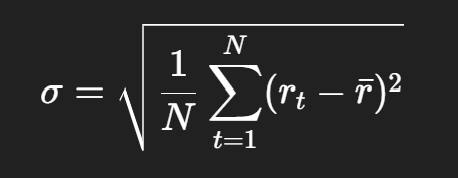

*2) Beta*
- While volatility measures total risk, Beta measures sensitivity to the overall market in terms of how much it moves in comparison.
- So, if the market goes up or down, Beta can help us indicate if a specific stock will follow the market trend.
- If Beta > 1, it moves more than the market, if it's less than 1, the stock tends to be more defensive and moves less than the market, and finally if Beta < 0, it moves against the market which is perfect for a diversification strategy to offset stocks with higher Betas in this risk-free approach.
- Although yfinance does offer a Beta, there are potential inaccuracies with it as different stock ticker platforms display different values. In our scenario we will use the following formula for Beta:

First, we will find the covariance of the stock's daily returns in comparison to the market's daily returns. If the market and stock are in the same direction in movement, positive covariance, if they move opposite, covariance is negative, or if there is no correlation, covariance is near 0. Then, we divided the covariance by the variance of the market. 

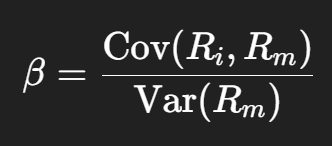

*3) Market Capitalization*
- Market Cap is a good predictor of a firm's financial stability. In simple terms, market cap is how big the company is. It is found by multiplying the price per share of the stock with the number of shares outstanding.
- Typically, large cap stocks are safer and more liquid as they are less volatile to market activity and are historically large companies with solid financial performance. Small cap stocks tend to be riskier, but as a result, they can offer greater rewards as they grow and vary in price faster than a large cap.
- Ideally, for a risk-free strategy, more large cap stocks would be preferred. However, with project guidelines, there must be at least one small cap stock chosen which we will account for.
- To find market cap, we will use the automatic function built into yfinance

*4) Sector Classification*
- Sector exposure is essential for avoiding industry concentration risk. Diversification across sectors ensures that a single event or macro shock does not destory the healthy of our entire portfolio. It also enhances  the process for optimization as having a variety of less-correlated assets to work with for minimum variance optimization is good because it helps us allocate our money into different baskets of sorts.
- We got the sector using yfinance built-in functions and grouped it into dictionaries based on sector.

In [20]:
# Get/calculate volatility (std), beta, market cap, and sectors

metrics_df = pd.DataFrame(columns=['Ticker', 'Volatility', 'Beta', 'MarketCap', 'Sector'])

# use market indexes to get beta
market_index = "^GSPC"
market_hist = yf.download(market_index, start=start_date, end=end_date)
market_prices = market_hist["Close"].dropna()
market_returns = market_prices.pct_change().dropna()

# Loop through filtered tickers
for ticker in filtered_lst:

    try:
        prices = daily_data['Adj Close'][ticker]
    except KeyError:
        prices = daily_data['Close'][ticker]

    prices = prices.dropna()
    if prices.empty:
        continue

    returns = prices.pct_change().dropna()
    if returns.empty:
        continue
        
    # daily standar deviation
    volatility = returns.std(ddof=0)     

    aligned = pd.concat([returns, market_returns], axis=1, join="inner")
    aligned.columns = ["Stock", "Market"]

    # covariance(stock, market)
    cov_sm = aligned.cov(ddof=0).iloc[0,1]

    # variance(market)
    var_market = aligned["Market"].var(ddof=0)

    if var_market == 0 or pd.isna(cov_sm):
        beta = np.nan
    else:
        beta = cov_sm / var_market

    info = yf.Ticker(ticker).info
    mcap = info.get("marketCap", np.nan)
    sector = info.get("sector", "Unknown")

    metrics_df.loc[len(metrics_df)] = [
        ticker,
        volatility,
        beta,
        mcap,
        sector
    ]

metrics_df = metrics_df.dropna(subset=['Volatility', 'MarketCap']).reset_index(drop=True)

print(metrics_df)

C:\Users\maxba\AppData\Local\Temp\ipykernel_29268\552511737.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  market_hist = yf.download(market_index, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


     Ticker  Volatility      Beta      MarketCap                  Sector
0     SU.TO    0.017002  0.696437    75742986240                  Energy
1      ABBV    0.016296  0.432525   408477925376              Healthcare
2       LOW    0.014931  0.657633   130010431488       Consumer Cyclical
3      AUST    0.055406  0.997127       20607966         Basic Materials
4        TD    0.011049  0.406171   142539587584      Financial Services
5      AMZN    0.022084  1.392550  2407543603200       Consumer Cyclical
6       AXP    0.019930  1.361972   247017324544      Financial Services
7       GCT    0.046741  1.810837     1319065600              Technology
8        BK    0.014981  0.921154    76035538944      Financial Services
9    EXE.TO    0.018792  0.266672     1741736320              Healthcare
10    CMCSA    0.017515  0.658270    98932678656  Communication Services
11     SHOP    0.037385  2.308689   201720561664              Technology
12     COST    0.013468  0.502885   392122433536   

## Rationale for Weighted Scoring Algorithm
To decide the strongest stocks, we decided to make a weighted scoring function, allocating points based on volatility, Beta, and market cap.
Since each metric is measured in different units (percentage, ratio, dollars), it wasn't a case of comparing apples-to-apples so this method made the most logical sense.

We set the max score at 100, and allocated weights for different sections based on importance.
- Volatility (45 points)
- Beta (35 Points)
- Market Cap (20 Points)

Volatility was given the highest weighting as it has the highest impact on risk and is the best measurement of how much a stock will move based on it's historic data. Since it tells us exactly how "jumpy" a stock is, it's the perfect thing to hold the most importance as our goal is for our portfolio's value to vary from the starting value by the minimum amount.

Next, Beta was given the second highest weighting as it measures the resistance of a stock to the market. Although 5 days is a short time period, if a specific news or market event were to take place during the time we're analyzing our portfolio, we need our stock to not be impacted as heavily as other more volatile ones. So, prioritzing a low Beta is very important.

Finally, Market Cap takes the least amount of weighting. While it still is good to have mainly large cap stocks that are less immune to fluctuations, factors such as beta and historic volatility should take precedence. Additionally, it's possible for a small cap to have little movement, and Volatility and Beta tend to be stronger indicators of risk.

For Volatility, the ranges we used to score were:
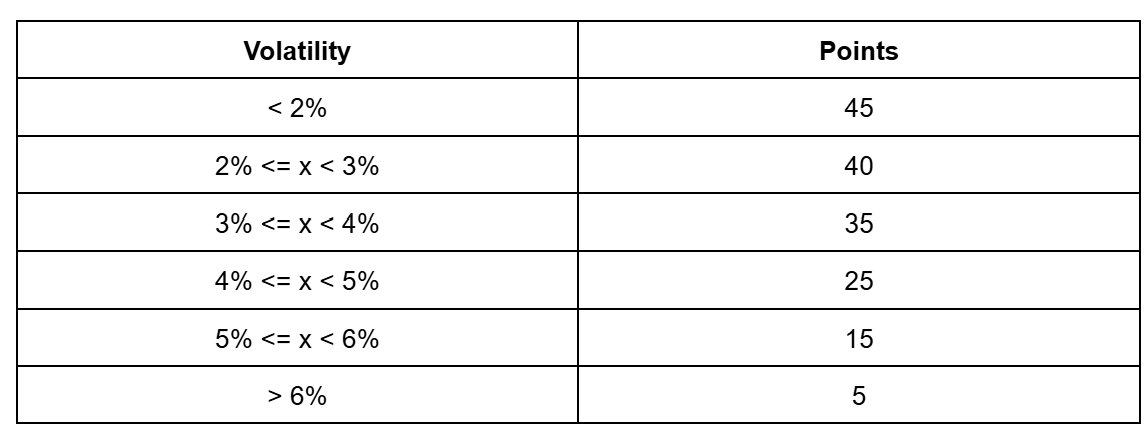

Using this, we were very critical in changes in volatility since we want the stocks our algorithm to picks to have the lowest possible volatility. Just a shift/increase of 1% in volatility will act as a 5 point deduction as we really want to prioritize stocks with volatilities less than 4%. After the 4% margin, any additional increases in volatility will be 10 point deductions, making it near impossible for our program to pick a stock with greater than 4% volatility, ensuring we get a stock with a track record of little fluctuations.

For Beta, the ranges we used to score were:
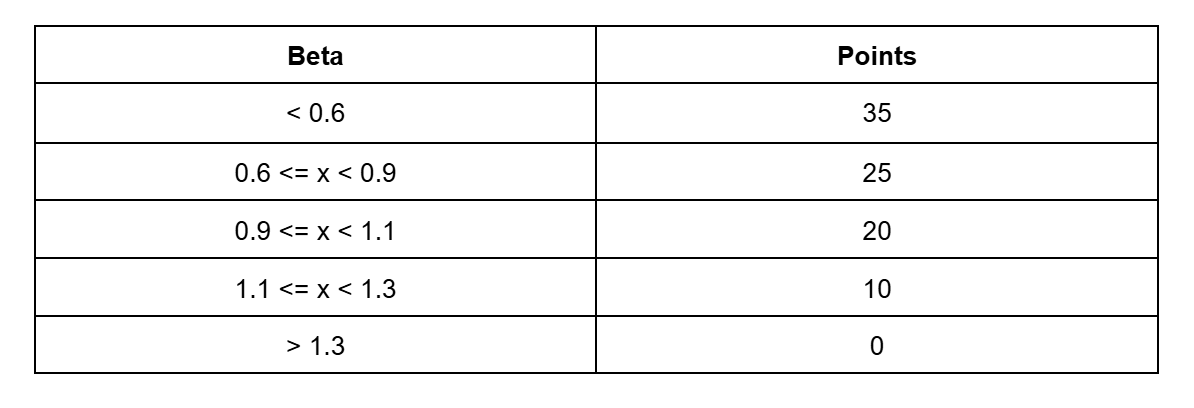

With Beta, we really wanted to prioritize stocks within our first bucket of <0.6. From there, the bucket between 0.6 and 0.9 Beta gets a 10 point deduction, and anything greater than 1 serves as no points as they would be useless to our risk-free portfolio due to their lack of resistance to the market and high tendency to shift in price.

For Market Cap, the ranges we used to score were:
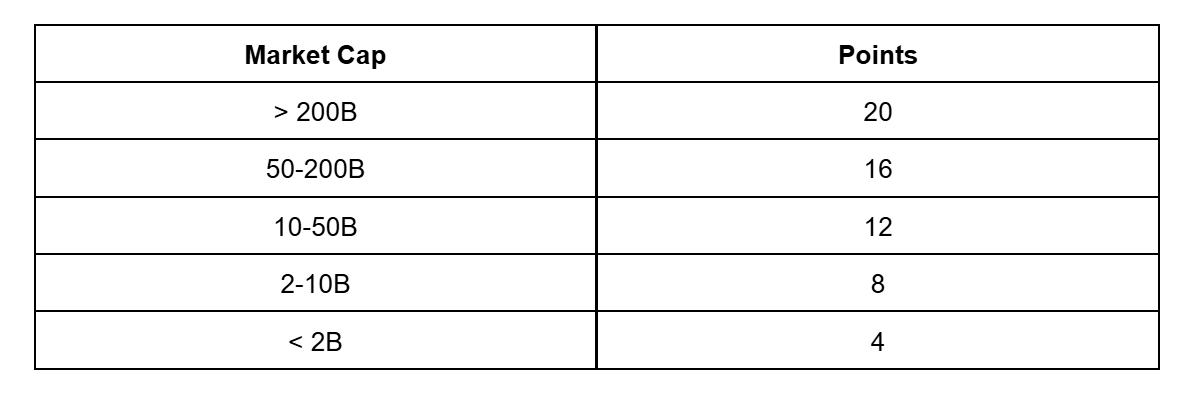

We set the max grouping at anything greater than $200B in market cap. Unlike the sections for Beta and volatility, we were less critical about stocks falling in other groupings, using a standard 4 point deduction for every bucket, as market cap does not take as much prominence in the risk-adversity of our portfolio.


In [21]:
# Use the weighted scoring algorithm in the doc to provide a score /100 per stock

scored_df = metrics_df.copy()

# Volatility scoring function
def vol_points(v):
    # v is daily volatility (e.g., 0.02 = 2%)
    if v < 0.02:
        return 45
    elif v < 0.03:
        return 40
    elif v < 0.04:
        return 35
    elif v < 0.05:
        return 25
    elif v < 0.06:
        return 15
    else:
        return 5

# Beta scoring function
def beta_points(b):
    # if no beta or if error in calculations, provide a neutral score
    if pd.isna(b):
        return 20  
    if b < 0.6:
        return 35
    elif b < 0.9:
        return 25
    elif b < 1.1:
        return 20
    elif b < 1.3:
        return 10
    else:
        return 0

# Market cap scoring function
def cap_points(m):
    # thresholds in dollars
    if m > 200e9:
        return 20
    elif m >= 50e9:
        return 16
    elif m >= 10e9:
        return 12
    elif m >= 2e9:
        return 8
    else:
        return 4

# Apply scoring table
scored_df['VolPts']  = scored_df['Volatility'].apply(vol_points)
scored_df['BetaPts'] = scored_df['Beta'].apply(beta_points)
scored_df['CapPts']  = scored_df['MarketCap'].apply(cap_points)

# Final score out of 100
scored_df['Score'] = scored_df['VolPts'] + scored_df['BetaPts'] + scored_df['CapPts']

print(scored_df[['Ticker','Volatility','Beta','MarketCap','Sector','Score']])


# dictionary: sector → list of tickers
sector_dict = {}  

for _, row in scored_df.iterrows():
    sector = row['Sector']
    ticker = row['Ticker']
    
    # create key if doesn't exist
    if sector not in sector_dict:
        sector_dict[sector] = []
    
    # append ticker
    sector_dict[sector].append(ticker)

# Preview the grouping
for sec, tics in sector_dict.items():
    print(f"{sec}: {tics}")

     Ticker  Volatility      Beta      MarketCap                  Sector  \
0     SU.TO    0.017002  0.696437    75742986240                  Energy   
1      ABBV    0.016296  0.432525   408477925376              Healthcare   
2       LOW    0.014931  0.657633   130010431488       Consumer Cyclical   
3      AUST    0.055406  0.997127       20607966         Basic Materials   
4        TD    0.011049  0.406171   142539587584      Financial Services   
5      AMZN    0.022084  1.392550  2407543603200       Consumer Cyclical   
6       AXP    0.019930  1.361972   247017324544      Financial Services   
7       GCT    0.046741  1.810837     1319065600              Technology   
8        BK    0.014981  0.921154    76035538944      Financial Services   
9    EXE.TO    0.018792  0.266672     1741736320              Healthcare   
10    CMCSA    0.017515  0.658270    98932678656  Communication Services   
11     SHOP    0.037385  2.308689   201720561664              Technology   
12     COST 

## Forming the top 25 stocks dataframe
- To maximize our diversification, we will select the top 25 stocks according to the scores allocated by our scoring algorithm, which is the maximum amount we are allowed to have. This will protect our portfolio from single-company risk.
- Using the concept of diversification, we will also spread our selection of stocks accross all sectors so that our portfolio is not entirely dependent on the how well a specific sector performs. Thus, we will pick the top 5 stocks, or the maximum amount of stocks if there are less than 5, with the best score from each sector and from that, we will pick the top 25 stocks with the best scores. This way we will not have more than 5 stocks per sector.


In [22]:
# Take the top 5 from each sector (based on their score /100) and put them in a new dataframe
def sector_top5(df,sector):
    top5_count = 0
    sector_top5 = pd.DataFrame() # top 5 tickers of a sector with the best scoring
    for i in range(len(df)):
        if df.iloc[i]['Sector'] == sector:
            top5_count += 1
            if top5_count > 5:
                top5_count = 5
                smallest_score = sector_top5['Score'].min()
                smallest_score_index = sector_top5['Score'].idxmin()
                if df.iloc[i]['Score'] > smallest_score:
                    sector_top5.loc[smallest_score_index] = df.iloc[i]
            else:
                sector_top5 = pd.concat([sector_top5,df.iloc[[i]]])
    return sector_top5

sector_lst = list(sector_dict.keys()) # creates a list of all the sectors
all_sectors_top5 = pd.DataFrame()
for sector in sector_lst:
    df_sector_top5 = sector_top5(scored_df,sector)
    all_sectors_top5 = pd.concat([all_sectors_top5,df_sector_top5])

# Then return the top 25
# sort stocks from highest score to lowest
all_sectors_top5 = all_sectors_top5.sort_values('Score', ascending=False)
top_25_stocks = all_sectors_top5.head(25) # top 25 stocks
# reset index 
top_25_stocks = top_25_stocks.reset_index(drop=True)
print(top_25_stocks)

     Ticker  Volatility      Beta      MarketCap                  Sector  \
0      ABBV    0.016296  0.432525   408477925376              Healthcare   
1      COST    0.013468  0.502885   392122433536      Consumer Defensive   
2       PEP    0.014266  0.142821   200049557504      Consumer Defensive   
3     TD.TO    0.010538  0.342784   200823701504      Financial Services   
4     RY.TO    0.010371  0.542131   299027300352      Financial Services   
5        TD    0.011049  0.406171   142539587584      Financial Services   
6        SO    0.011104  0.039190    98053390336               Utilities   
7      T.TO    0.011593 -0.060614    28405800960  Communication Services   
8    SAP.TO    0.014393  0.431235    15893915648      Consumer Defensive   
9      CSCO    0.014864  0.878911   301764837376              Technology   
10    SU.TO    0.017002  0.696437    75742986240                  Energy   
11      LOW    0.014931  0.657633   130010431488       Consumer Cyclical   
12    CMCSA 

# Market Cap Mix: Check for a small-cap
To meet the requirement of at least one small-cap:

- Check if the 25th stock in our dataframe is a small-cap (we will need the last row of the dataframe to be a small-cap for the mininum variance portfolio optimization). If it is we will proceed with the minimum varaicnace portfolio optimization.
- If the last row is not a small-cap, check if there already is a small-cap in the entire top 25 stocks. If there is a small-cap, we will move the first small-cap we find in the dataframe to the last row to fufill the requirement for our minimum variance optimization.
- If our top 25 stocks dataframe does not contain a small-cap, we will take the best scoring small-cap from the entire list of tickers and we will replace the last row of our top 25 stocks with it.

In [23]:
# check for small cap in the last row of the top 25 stocks as code determining weight of portfolio will consider this
small_cap = 2e9
last_row_market_cap = top_25_stocks['MarketCap'].iloc[-1]
market_cap = top_25_stocks['MarketCap']
if last_row_market_cap < small_cap:
    print("Small cap in the 25th row found")
# move small cap to the last row if there is a small cap in the top 25 stocks
elif (market_cap < small_cap).any():
    for row in top_25_stocks.itertuples():
        if row.MarketCap < small_cap:
            top_25_stocks = top_25_stocks.drop(row.Index)
            row_df = pd.DataFrame([row._asdict()]).set_index('Index')
            top_25_stocks = pd.concat([top_25_stocks,row_df])
            print("Moved small cap to 25th row")
            break
# get the best scoring small cap from the dataframe of all the scored stocks and replace it with the stock of the last row of the top 25 stocks            
else:
    small_cap_df = scored_df[scored_df['MarketCap'] < small_cap].copy()   
    small_cap_df = small_cap_df.sort_values('Score', ascending=False)
    top_score_small_cap = small_cap_df.iloc[0]
    # replace the last stock of the top 25 with the small cap with the best score
    top_25_stocks.iloc[-1] = top_score_small_cap
    print("Added small cap to 25th row")

Moved small cap to 25th row


# Market Cap Mix: Check for a large-cap
To meet the requirement of at least one large-cap:

- Check if there is a large-cap in the top 25 stocks.
- If there is not, take the best scored large-cap from the scored stocks and replace it with the second last row of the 25 stocks.

In [24]:
# check for large-cap
large_cap = 10e9
market_cap = top_25_stocks['MarketCap']
if (market_cap > large_cap).any():
    print('Large-cap found in the top 25 stocks')
# get the best scoring large cap from the dataframe of all the scored stocks and replace it with the stock of the last row of the top 25 stocks            
else:
    large_cap_df = scored_df[scored_df['MarketCap'] > large_cap].copy()   
    large_cap_df = large_cap_df.sort_values('Score', ascending=False)
    top_score_large_cap = large_cap_df.iloc[0]
    # replace the second last stock of the top 25 with the small cap with the best score
    top_25_stocks.iloc[-2] = top_score_large_cap

print(top_25_stocks)

Large-cap found in the top 25 stocks
     Ticker  Volatility      Beta      MarketCap                  Sector  \
0      ABBV    0.016296  0.432525   408477925376              Healthcare   
1      COST    0.013468  0.502885   392122433536      Consumer Defensive   
2       PEP    0.014266  0.142821   200049557504      Consumer Defensive   
3     TD.TO    0.010538  0.342784   200823701504      Financial Services   
4     RY.TO    0.010371  0.542131   299027300352      Financial Services   
5        TD    0.011049  0.406171   142539587584      Financial Services   
6        SO    0.011104  0.039190    98053390336               Utilities   
7      T.TO    0.011593 -0.060614    28405800960  Communication Services   
8    SAP.TO    0.014393  0.431235    15893915648      Consumer Defensive   
9      CSCO    0.014864  0.878911   301764837376              Technology   
10    SU.TO    0.017002  0.696437    75742986240                  Energy   
11      LOW    0.014931  0.657633   130010431488   

# Minimum Variance Portfolio Optimization

Now that we have selected the 25 stocks we would like to invest in, it is time to determine how much to allocate into each stock. This part constructs a minimum-variance portfolio that aims to achieve the lowest possible volatility while following the constraints listed in the assignment. Rather than chasing maximum returns, this strategy prioritizes preserving our wealth and reducing risk. 
 
# Why Minimum Variance?
The main idea is that by combining assets with different return patterns, we can reduce overall portfolio risk below what we would have if we put the same amount in every stock. This happens because stock prices don't all move together. When some stocks fall, others may rise or remain stable. We can use this to our advantage to invest in two assets that react oppositely to market news, that way if one moves, the other will too, just in the other direction. Lower volatility means our portfolio moves less and stays close to a 0% return.

# Why Optimization Instead of Monte Carlo Simulation?
 
You, like my teammates, might wonder, "Why not just run Monte Carlo simulations to try millions of random portfolio combinations?" 
Here's why MVP optimization is superior:

- Optimization finds the mathematically proven minimum variance portfolio every time. Meanwhile Monte Carlo might get close but is never guaranteed to find the true optimum
- MVP Opt solves problems in seconds using convex optimization algorithms. Monte Carlo needs millions of iterations to get the same answer, taking much longer
- Optmization returns the same portfolio every time, while Monte Carlo will give different ones each time based on the given seed

# Our Strategy
We implement a three-stage process:
1. Find the theoretical minimum variance portfolio from our list of stocks
2. Apply the constraints and refine to ensure a proper portfolio (that fulfills the requirements)
4. Use mvp optimization a second time and return the results 

In [25]:
tickers = top_25_stocks['Ticker'].tolist()

# Build a dictionary mapping ticker to sector for sector exposure calculations
sectors = {}

for ticker in tickers:
    try:
        stock = yf.Ticker(ticker)
        sector = stock.info.get('sector', 'Unknown')
        sectors[ticker] = sector
    except:
        sectors[ticker] = 'Unknown'

# Portfolio Constraints

| Constraint | How | Explanation |
|------------|-------|-----------|
| **No Short Selling** | Weights >= 0 | We only buy stocks (no betting against them) |
| **Max Weight per Stock** | Weights <= 15% | Prevents over-concentration in any single company |
| **Min Weight per Stock** | 1 / (2 * num_tickers) | Ensures we don't hold like 0.001% of a company |
| **Max Sector Exposure** | 40% | Prevents industry-specific risk |
| **Minimum Holdings** | 10-25 stocks | Ensures adequate diversification |
| **Small-Cap Requirement** | >= 1 stock | Adds diversification |


In [26]:
# Values needed for constraints
num_tickers = len(tickers)
min_weight_if_included = 1 / (2 * num_tickers)  
max_weight = 0.15 # No stock can exceed 15%
max_sector_weight = 0.40 # No sector can exceed 40%
min_stocks = 10 # Must have at least 10 stocks
small_epsilon = 0.001 # Threshold to remove negligible stocks

# Data Collection & Processing

We download one year of historical price data to estimate the covariance matrix. One year will provide us with enough data points to understand the typical market behavior while remaining relevant to the current market conditions.

We will try using adjusted prices as they account for stock splits and dividends. Without adjustment, a 2-for-1 stock split would wrongly appear as a 50% loss.

In [27]:
# Download historical data
end_date = (datetime.now() - timedelta(days=1)).strftime('%Y-%m-%d')
start_date = (datetime.now() - timedelta(days=365)).strftime('%Y-%m-%d')

prices_all = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=True)

# Tries to get adjusted closes if possible
# Adjusted close is better than close in case of stock splits
if isinstance(prices_all.columns, pd.MultiIndex):
    if 'Adj Close' in prices_all.columns.get_level_values(0):
        prices = prices_all['Adj Close'].copy()
    else:
        prices = prices_all['Close'].copy()
else:
    prices = prices_all.copy()

# Filters out tickers that don't have yf data
available = [t for t in tickers if t in prices.columns]

prices = prices[available]   
tickers = available
num_tickers = len(tickers)

# Covariance Matrix Estimation
 
The **covariance matrix** is the heart of our portfolio optimization. It helps us to model:
- Variance: How volatile each individual stock is
- Covariance: How different stocks move with one another

What this means:
- If two stocks have a positive covariance they will tend to move in the same direction
- If two stocks have a negative covariance they will move in opposite directions (great for our diversification woohoooo!)
- If they have NO covariance, their stock movements will be completely independent from one another

The minimum variance portfolio optimizer uses this matrix to find combinations of stocks that offset each other's volatility.

In [28]:
# Calculate returns and covariance matrix
returns = prices.pct_change(fill_method=None).dropna(how='all')
cov_matrix = returns.cov().values

# Map tickers to sectors in order for future constraint reinforcement
ticker_sectors = [sectors[t] for t in tickers]
unique_sectors = sorted(set(ticker_sectors))

# Step 1: Initial Optimization

Minimum variance optimization solves this mathematical problem:
 
# **σ²ₚ = wᵀΣw**

Where:
- wT = the transposed vector of portfolio weights (essentially just how much to invest in each stock)
- Σw = the covariance matrix (the thing we made just now that shows the risk relationships between stocks)
- σ²ₚ = portfolio variance (we want this to be as low as possible)
 
The optimizer searches through all possible weight combinations to find the one that produces the lowest and least volatile returns. It uses negative correlations and low covariances to cancel out individual stock volatility.
 
For our use of it, we have implemented the CVXPY library to solve this.

In [29]:
# Minimizing Portfolio Variance (THANK YOU CVXPY)
w = cp.Variable(num_tickers)
objective = cp.Minimize(cp.quad_form(w, cov_matrix))

# Basic constraints
constraints = [
    cp.sum(w) == 1, # Weights sum to 100%
    w >= 0, # No short selling
    w <= max_weight # Max 15% per stock
]

# Add Sector Constraints (40% max)
for sector in unique_sectors:
    indices = []
    for i in range(len(tickers)):
        if sectors[tickers[i]] == sector:
            indices.append(i)
    
    if indices:
        total_sector_weight = cp.sum(w[indices])
        constraints.append(total_sector_weight <= max_sector_weight)

# Solve the optimization problem (I LOVE YOU CVXPY)
problem = cp.Problem(objective, constraints)
result = problem.solve()

# Step 2: Cleaning and Portfolio Refinement

In testing, the optimizer often assigned tiny weights to many stocks (Like 0.001% D:). These are impractical so we zero out positions below 0.1% and ensure we have at least 10 holdings in our portfolio. 

In [30]:
# Zero out companies with really small allocations
raw_weight = np.maximum(w.value, 0)  
raw_weight[raw_weight < small_epsilon] = 0

# Makes list of all tickers that actually have value
included_idx = np.where(raw_weight > 0)[0].tolist()

# Ensure we have at least 10 stocks
# If not, pick top weights until we have the minimum number of stocks
if len(included_idx) < min_stocks:
    biggest = []
    for i in range(len(raw_weight)):
        biggest.append((raw_weight[i], i))
    
    biggest.sort(reverse=True)
    
    # Add top stocks until we reach the minimum
    for w, i in biggest:
        if i not in included_idx:
            included_idx.append(i)
        if len(included_idx) >= min_stocks:
            break

included_idx = sorted(included_idx)
selected_tickers = [tickers[i] for i in included_idx]

# Step 3: Final Optimization with Minimum Weights

Now we optimize the portfolio again using only our selected stocks, but with an additional constraint. Each included stock must have at least the weight derived from the weight fromula from before. In a real-world scenario, this ensures that positions are large enough to justify transaction costs, but here, we just do it because it's a requirement :)

In [31]:
# DO IT AGAIN CVXPY 
# WE GETTING THE PROPER VALUES THIS TIMEEEE
new_num_stock = len(included_idx)
min_weight_if_included = 1 / (2 * new_num_stock)
weight_2 = cp.Variable(new_num_stock)

# Build sub-covariance matrix out of the stocks with actual weights
cov_sub = cov_matrix[np.ix_(included_idx, included_idx)]

second_objective = cp.Minimize(cp.quad_form(weight_2, cov_sub))

second_constraints = [
    cp.sum(weight_2) == 1,
    weight_2 >= min_weight_if_included,   
    weight_2 <= max_weight
]

# Add sector constraints again for the new portfolio (40% max per sector)
for sector in unique_sectors:
    indices = []
    for i in range(len(included_idx)):
        stock = tickers[included_idx[i]]
        if sectors[stock] == sector:
            indices.append(i)
    
    if indices:
        total_sector_weight = cp.sum(weight_2[indices])
        second_constraints.append(total_sector_weight <= max_sector_weight)

# Solve the new optimization problem
problem_2 = cp.Problem(second_objective, second_constraints)
final_results = problem_2.solve(solver=cp.SCS)

# Map the optimized weights back to the full ticker list
final_weights = np.zeros(num_tickers)
final_weights[included_idx] = np.maximum(np.array(weight_2.value).flatten(), 0)

# Normalize to ensure weights sum exactly to 1
final_weights = final_weights / final_weights.sum()
final_weights = np.minimum(final_weights, max_weight)

# Portfolio volatility
portfolio_vol = np.sqrt(final_weights @ cov_matrix @ final_weights)

# Make results df
results = pd.DataFrame({
    "Ticker": tickers,
    "Weight": final_weights
}).sort_values("Weight", ascending=False)

# Filters to remove all holdings with zero weights
results = results[results['Weight'] > 0].reset_index(drop=True)

print(f"Portfolio Volatility: {round(portfolio_vol,6)}")
print(f"Started with {len(tickers)} stocks, now have {len(results)} stocks.")
print(results)

Portfolio Volatility: 0.006216
Started with 25 stocks, now have 16 stocks.
    Ticker    Weight
0    TD.TO  0.150000
1     T.TO  0.150000
2       SO  0.150000
3    AW.TO  0.107338
4   AIM.TO  0.059777
5   EXE.TO  0.044573
6     COST  0.042299
7   SAP.TO  0.040816
8    RY.TO  0.036422
9      PEP  0.031256
10  FTG.TO  0.031254
11    ABBV  0.031253
12   SU.TO  0.031252
13    AMZN  0.031250
14      GM  0.031250
15    GOOG  0.031249


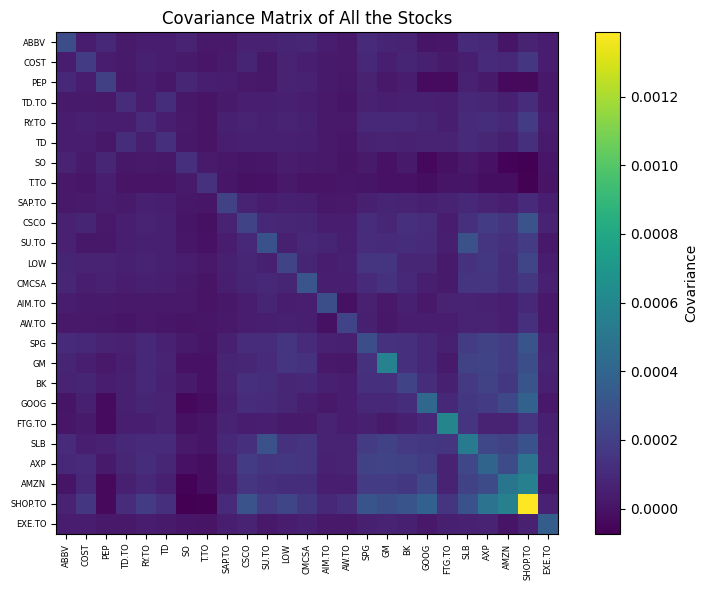

In [32]:
# If you're interested in seeing how the covariance matrix works or looks, here's a heatmap
# The darker the square, the less the two stocks move together
# Essentially the darker, the more the stocks balance each other's movements out

plt.figure(figsize=(8,6))
plt.imshow(cov_matrix, cmap="viridis")
plt.colorbar(label="Covariance")
plt.title("Covariance Matrix of All the Stocks")
plt.xticks(range(num_tickers), tickers, rotation=90, fontsize=6)
plt.yticks(range(num_tickers), tickers, fontsize=6)
plt.tight_layout()
plt.show()

# Final Portfolio Construction
 
Now we convert our optimal weights into actual shares we can buy (including fractional shares).


In [33]:
# Step 0: Make adjusted weights dataframe
results['Weight'] = results['Weight'] / results['Weight'].sum()

# Make sure no weights are above 15%
results['Weight'] = results['Weight'].clip(upper=max_weight)

# Do the thing again
results['Weight'] = results['Weight'] / results['Weight'].sum()

# Step 1: Convert investment amount to USD
# This will make it easier when it comes to transaction costs and buying both canadian and american equities

investment_cad = 1_000_000

usd_cad_ticker = yf.Ticker("CADUSD=X")
cad_to_usd = usd_cad_ticker.info.get('regularMarketPrice')  # Current exchange rate

investment_usd = investment_cad * cad_to_usd

print(f"Total Budget: ${investment_cad:,.2f} CAD = ${investment_usd:,.2f} USD")
print(f"Exchange Rate: 1 USD = {1/cad_to_usd:.4f} CAD")
# Step 2: Get current prices for each stock
current_prices = {}
total_shares = 0

for ticker in results['Ticker']:
    stock = yf.Ticker(ticker)
    price = stock.info.get('regularMarketPrice')
    current_prices[ticker] = price

# Step 3: Calculate allocation, shares, and fees
portfolio_data = []

# First, calculate fees
for ticker in results['Ticker']:
    weight = results[results['Ticker'] == ticker]['Weight'].values[0]
    price = current_prices[ticker]

    # Check if this is a Canadian stock
    is_canadian = ticker.endswith('.TO')
    
    # Amount allocated to this stock (in USD)
    allocated_usd = investment_usd * weight
    
    if is_canadian:
        # Convert allocated USD to CAD for Canadian stocks
        allocated_cad = allocated_usd / cad_to_usd
        shares = allocated_cad / price
    else:
        # Is US equity
        shares = allocated_usd / price
        
    total_shares += shares

# Calculate single transaction fee for entire portfolio
total_fee_usd = min(2.15, 0.001 * total_shares)
total_fee_cad = total_fee_usd / cad_to_usd

# Investable amount after fees
investable_usd = investment_usd - total_fee_usd  # <-- FIXED: Changed total_fees_usd to total_fee_usd

# Now allocate using the investable amount
for ticker in results['Ticker']:
    weight = results[results['Ticker'] == ticker]['Weight'].values[0]
    price = current_prices[ticker]

    # Check if this is a Canadian stock
    is_canadian = ticker.endswith('.TO')
    
    # Amount allocated to this stock (in USD)
    allocated_usd = investable_usd * weight
    
    if is_canadian:
        # Convert allocated USD to CAD for Canadian stocks
        allocated_cad = allocated_usd / cad_to_usd
        
        # Determine final amount of shares per stock
        shares_final = allocated_cad / price
        
        # How much it's worth in CAD
        value_cad = shares_final * price
        
        portfolio_data.append({
            'Ticker': ticker,
            'Price': price,
            'Currency': 'CAD',
            'Shares': shares_final,
            'Value (CAD)': value_cad,
            'Weight': weight  
        })
    else:
        # USA USA USA
        # Determine final amount of shares per stock
        shares_final = allocated_usd / price
        
        # How much it's worth in USD
        value_usd = shares_final * price
        
        # How much it's worth in CAD
        value_cad = value_usd / cad_to_usd  
        
        portfolio_data.append({
            'Ticker': ticker,
            'Price': price,
            'Currency': 'USD',
            'Shares': shares_final,
            'Value (CAD)': value_cad,  
            'Weight': weight  
        })

# Step 4: Create final DataFrame
Portfolio_Final = pd.DataFrame(portfolio_data)
Portfolio_Final.index = range(1, len(Portfolio_Final) + 1)

# Now all values are in CAD, so just sum them and stuff
total_invested_cad = Portfolio_Final['Value (CAD)'].sum()

# Display results
print(f"\nTotal Fees:      ${total_fee_cad:,.2f} CAD (${total_fee_usd:,.2f} USD)")  
print(f"Total Invested:    ${total_invested_cad:,.2f} CAD")
print(f"Cash Remaining:    ${investment_cad - total_fee_cad - total_invested_cad:,.2f} CAD")  
print(f"Weight Sum:        {Portfolio_Final['Weight'].sum():.6f}")
print(f"\n{Portfolio_Final.to_string()}\n")

# Step 5: Export CSV file
Stocks_Final = Portfolio_Final[['Ticker', 'Shares']].copy()
group_number = "07"  

Stocks_Final.to_csv(f"Stocks_Group_{group_number}.csv", index=False)
print(f"Saved Stocks_Group_{group_number}.csv")
print(f"\n{Stocks_Final.to_string(index=False)}")

Total Budget: $1,000,000.00 CAD = $708,697.14 USD
Exchange Rate: 1 USD = 1.4110 CAD

Total Fees:      $3.03 CAD ($2.15 USD)
Total Invested:    $999,996.97 CAD
Cash Remaining:    $0.00 CAD
Weight Sum:        1.000000

    Ticker     Price Currency        Shares    Value (CAD)    Weight
1    TD.TO  116.5900      CAD   1286.562962  150000.375731  0.150001
2     T.TO   18.3500      CAD   8174.407397  150000.375731  0.150001
3       SO   89.0410      USD   1193.886381  150000.375731  0.150001
4    AW.TO   37.4100      CAD   2869.283779  107339.906186  0.107340
5   AIM.TO    2.7700      CAD  21580.446894   59777.837895  0.059778
6   EXE.TO   20.7800      CAD   2145.010609   44573.320454  0.044573
7     COST  884.4375      USD     33.894476   42299.515567  0.042300
8   SAP.TO   38.7500      CAD   1053.330759   40816.566895  0.040817
9    RY.TO  212.0300      CAD    171.780380   36422.593976  0.036423
10     PEP  146.1200      USD    151.595282   31256.091469  0.031256
11  FTG.TO   10.3400    

# Before You Ask

Yes, we recognize if we wanted the **absolute lowest risk portfolio possible**, we could've just fed all of the tickers after being filtered into this optimizer. After all, in our tests, the optimization portion of the program only took 10 seconds to run even after being given 128 different stocks. However, we want a good grade. The competition results, frankly, matter the least to us. Being able to show this off on our resumes matters a ton, but nothing comes before grades. Hence, we've used metrics we discussed in class and explored in assignments, built a scoring algorithm (as one of our teammates have been able to build similar projects using them in the past), and applied ideas we learned in the presentations and past jupyter notebooks, to hopefully achieve our goal.

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Wendi Xue, Ammar Adam, Maximilian Bartoszek